In [1]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft
from scipy import signal
from sklearn.decomposition import PCA
import pywt

* center_sternum.txt: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively.

All .txt files give 16 columns index, in particular:
* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse
system.

### Assignments

Data preparation:

1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

Time and frequency analysis:

2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical
descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

Filter:

Implement your own filter, trying to extrapolate respiratory rate signal. Hint:

(a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

(b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

(c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal). (d) Find another method by yourselves.

Motivate your choice.

Metrics:

4.1. Respiratory Rate Per Minute(RPM): extrapolate RPM, make an histogram of the result. Does it follow a partiular distribution?

4.2. Respiratory Rate Variability(RRV): extrapolate RRV, explain why this parameter is important, and plot the results.

(OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate respiratory rate even when filter failed (e.g. look at particular threshold...).

In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index
sampling_rate = 200 # calibration tells us the sampling rate
df_init=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df_init['time_s'] = np.arange(0,df_init.shape[0])/sampling_rate # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 100 Hz)
df_init=df_init.set_index('time_s')
df_init

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


<AxesSubplot:xlabel='time_s'>

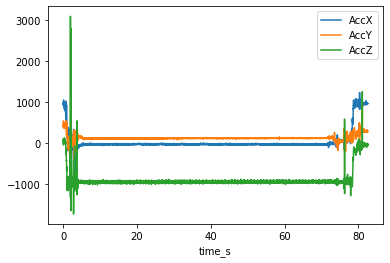

In [3]:
# now let's look at the acceleration vector by plotting its three components
acc_columns = ['AccX','AccY','AccZ']
gyro_columns = ['GyroX','GyroY','GyroZ']
df_init.plot(y=acc_columns)


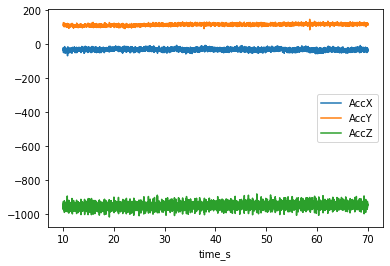

In [4]:
# we can see that the important time window is in the middle, where the supposedly periodic signal is happening
df_init.loc[10:70].plot(y=acc_columns)
df=df_init.loc[10:70]


Percentage of variance due to the selected component: 76.74%


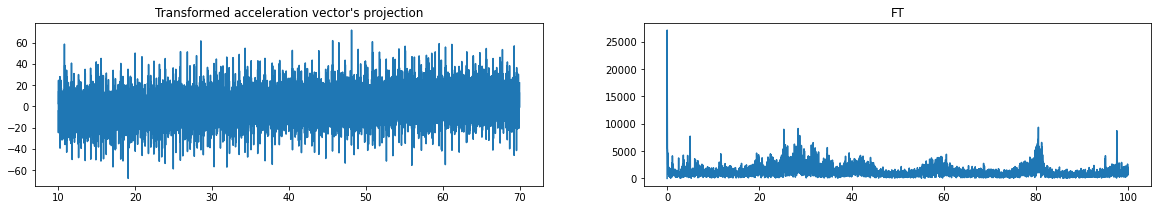

In [5]:
#TRY WITH PCA on this one, implemented by sklearn routine
pca=PCA(n_components=1) # we seek a single signal
# X must be (n_samples,n_features)
pca.fit(df[acc_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
accT=pca.transform(df[acc_columns]).reshape(-1)

sample_spacing = 1/sampling_rate
accT_FT=fft.fft(accT)
accT_FT_freq=fft.fftfreq(accT.size,sample_spacing)
N = int(accT_FT_freq.size/2) #ignoring negative frequencies since input is real valued
accT_freq_pos = accT_FT_freq[:N]
accT_FT_pos = np.abs(accT_FT[:N])



with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(df.index,accT)
    axs[0].set_title("Transformed acceleration vector's projection")
    axs[1].plot(accT_FT_freq[:N],np.abs(accT_FT[:N]))
    axs[1].set_title("FT")
    


<center><img src="img/wavelet_analysis.png" width="450"/></center>
<center>Image taken from 
<a href="https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442">this</a>
 article.</center>

# Wavelet transformation
The thing is that using FT across the whole time series only works well for stationary signals: but if we were to introduce perturbations that last a short time (such as noise!) $\Delta t$ by the uncertainty principle this results in a very messy and large $\Delta f$ frequency resolution. Using a Wavelet transofrmation, we can see at what time specific frequencies enter our signal: in particular, higher frequency noise can be resoluted in a shorter span of time, because of the nature of the uncertainty principle, while lower frequencies need to be analyzed for a longer span of time. The mathematical definition of a *continuous wavelet transform* is this:
$$
cwt(\tau,s) = \frac{1}{\sqrt{|s|}} \int_{-\infty}^{+\infty} x(t) \psi(\frac{t-\tau}{s}) dt
$$
Where $\psi$ is the *mother wavelet*, i.e. the specific type of wave we convolve with our signal, and $s$ is the *scale factor* of such mother wavelet. The suitable type of wavelet depends on the problem at hand, and the scale factor basically determines the frequency of said wavelet packet. Instead of a traditional FT, in which the time dependence is gone and its value only depends on the pure frequency, now the CWT decomposes a 1D time signal into a ND time series, where at each time instant we have the decomposition of the signal into N different wavelets used; when high frequency time-localized noise arises, CWT should be able to pinpoint that by presenting a high-frequency wavelet decomposition with high value.
### *Discrete Wavelet Transformation* (DWT)
DWT differs from the CWT via the resolution of the scale array; it benefits from lower computational complexity and less redundancy, but its implementation in libraries is formulated slightly differently. Basically, we are decomposing our signal using "harmonics" of a mother wavelet: this corresponds to iteratively decomposing the original signal via a low pass and high pass filters, dividing the signal in two subsets of half the lenght, one containing the finer details via the *wavelet function* $\psi_i$ and the other containing the approximation of the signal due to the corresponding traslating *scaling function* $\phi_i$ . At maximum level, the signal is approximated with the widest (lowest frequency) $\phi_i$. The final transformation result is a vector of lenght `n` as the original signal (as opposed to the (discretized) CWT, whose final result is a matrix of coefficients `n x m` where `m` is the array of wavelet scales used), whose first components are the coefficients `cA_n` of the maximum order approximation, and the rest are the details coefficients `cDn, Cdn-1,...`. 

Let's see this in practice with the simplest wavelet possible: the Haar wavelet. Let `x` and `y` be the signal datapoints with lenght `n`. If we split the dataset by computing the pair-wise average point of the dataset and storing the (symmetric) difference with the original signal, we end up with two `n/2` arrays; the approximation one contains the lower frequency signal and the difference one contains the higher frequency details; this is level 1 discrete wavelet decomposition, that arises when applying only one pair of high and low pass filters.


<center><img src="dwt_plots/original_signal_with_average.png" width="450"/></center>

By doing this further, applying the transformation and subdivision to the approximated signal until eventually we get to the maximum possible level, we separate everytime the details at a given higher frequency from the lower and lower frequency approximation.
At each level $i$, the signal is approximated by $n/2^i$ steps function, that is our *scaling function* $\phi_i$ multiplied by its $n/2^i$ coefficients. Reconstructing the previous $i-1$ approximation requires adding back the details previously omitted, and that correspond to the the wavelet function $\psi_i$ times its $n/2^i$ coefficients. By using this method of averaging out and storing the differences, we are basically applying the DWT method with the Haar wavelet and scaling function:

<center><img src="dwt_plots/haar_phi_psi.png" width="550"/></center>

Using different wavelets allows us to better capture the underlying signal via the scaling functions.

DWT is widely used in denoising and compressing tasks, since it allows us to identify small details (wavelets) coefficients, ideally due to unwanted noise. By setting those to zero according to some threshold condition, and reconstructing the signal, we get back a "smoothed out" signal that hopefully entails the features we are interested in.

Let's start:

In [6]:
# first let's get a list of all the possible wavelets that pywt provides
wavelist=pywt.wavelist(kind='discrete')
print(wavelist)

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


Which wavelet should we use? [Literature](https://journals.physiology.org/doi/epdf/10.1152/jappl.1999.86.3.1081) suggests *Daubechies 4* from the Daubechies family of wavelets. We apply the DWT using such wavelet to our signal, going up to the deepest level possible: depending on the FIR coefficients that define the filter, this turns out to be
$$
N_{max} = \lfloor \log_2 (\frac{n_{data}}{n_{filter} - 1}) \rfloor
$$
where $n_{data}$ and $n_{filter}$ are the lenght of the signal and the lenght of the FIR filter coefficients that define the transformation, respectively.

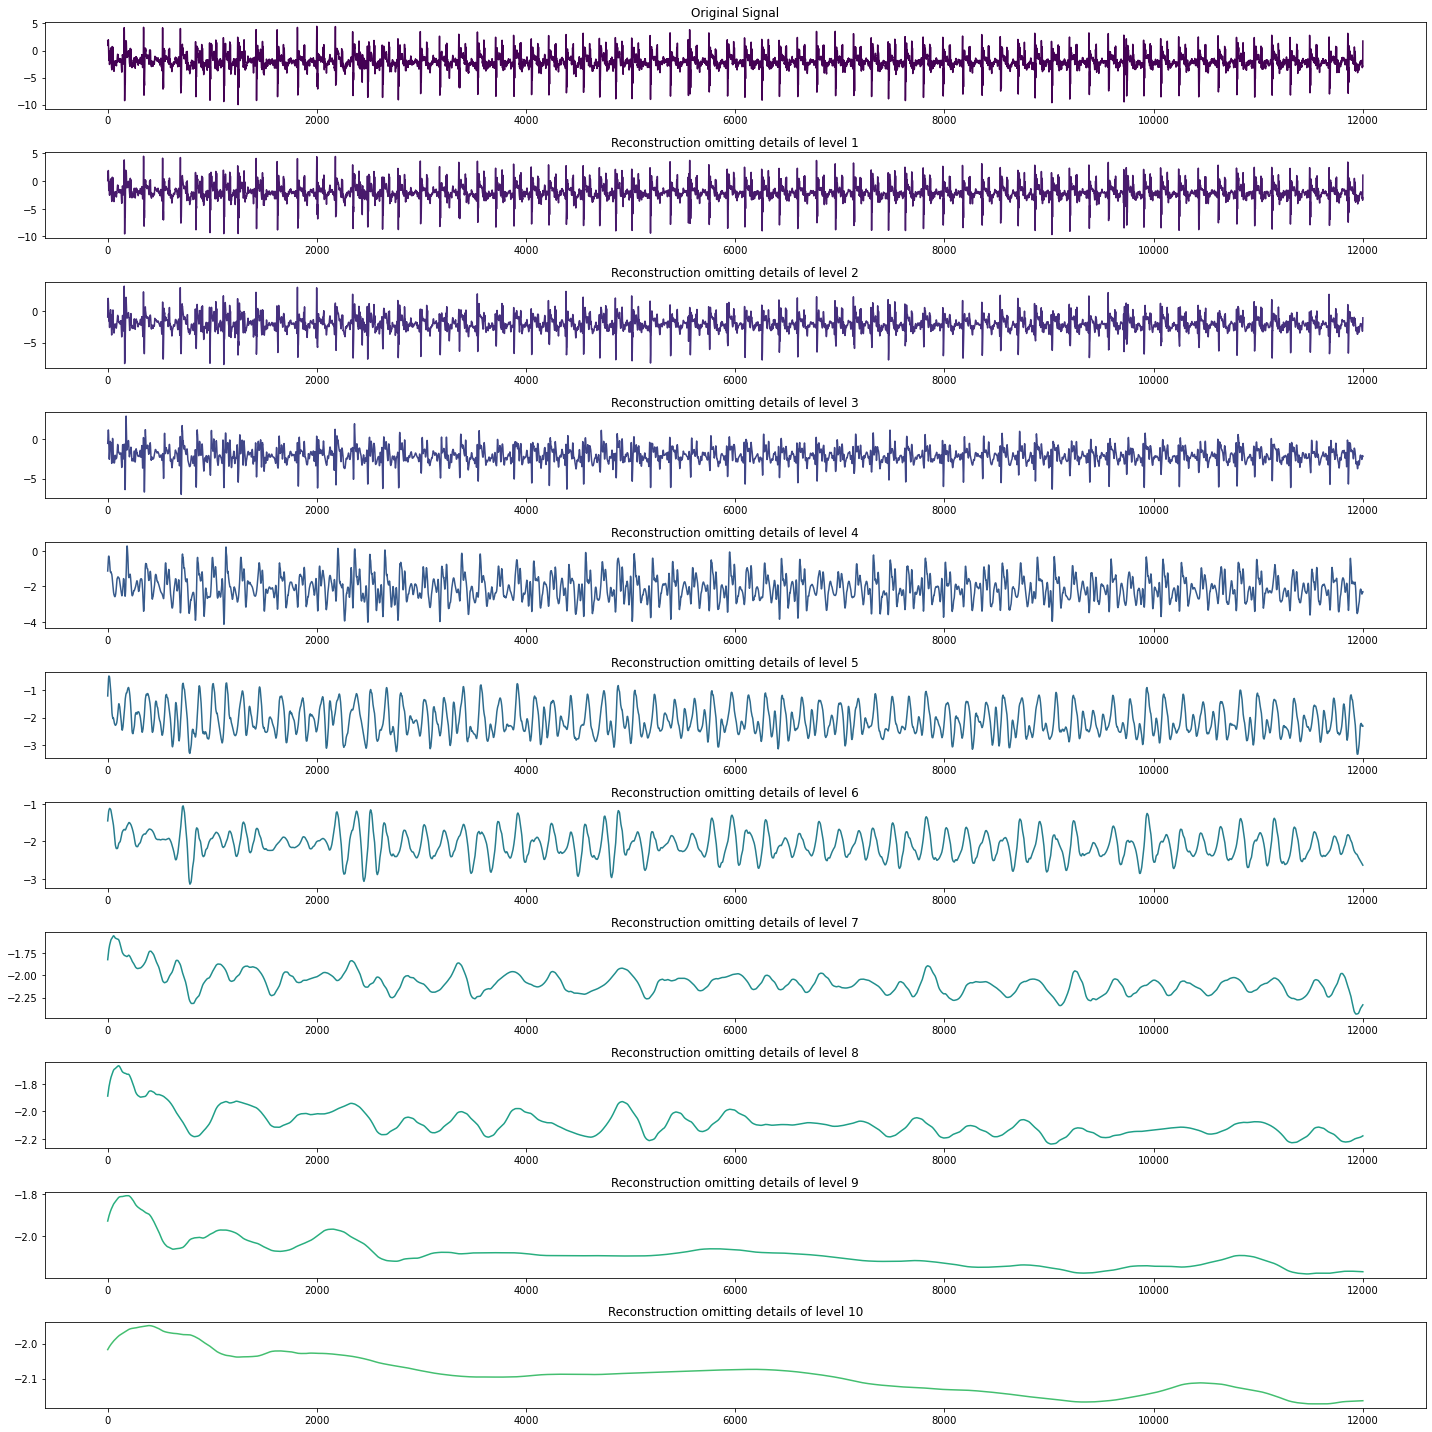

In [41]:
wvlet='db4'   # daubechies 4 wavelet
data = df['GyroX'].values   #Using GyroX data
mode = 'periodic'
# --------------- DECOMPOSITION

coefs=pywt.wavedec(data,wvlet,mode=mode) # this function applies the DWT decomposition up to the maximum possible level
                                             # coefs is then a list of arrays, the first one being the approximation coefficients
                                             # at level n and the rest being the n,n-1,... details coefficients.

#just to be sure, let's grab the levels of reconstruction through the same function pywt uses
n_max=pywt.dwt_max_level(len(data),wvlet)


# --------------- RECONSTRUCTION
# let's plot different reconstruction levels
from matplotlib import cm
colors=[cm.viridis(x) for x in np.linspace(0,0.7,n_max+1)]
fig,axs=plt.subplots(n_max+1,figsize=[20,20])
# first axis we plot the entire reconstruction
x_re = pywt.waverec(coefs,wvlet,mode=mode)
axs[0].plot(x_re,color=colors[0])
axs[0].set_title("Original Signal")
coefs_n=coefs.copy()

for level in range(1,n_max+1):
                                                 # coefs[-i] are the detail coefficients for lvl i transformation.
    coefs_n[-level] = np.zeros_like(coefs_n[-level]) # at each iteration, we ignore the i-th level of detail
    x_re=pywt.waverec(coefs_n,wvlet,mode=mode)
    axs[level].plot(x_re,color=colors[level])
    axs[level].set_title("Reconstruction omitting details of level "+str(level))

fig.tight_layout()
plt.show()


The previous plot shows the progressing levels of wavelet decomposition for our signal. Now for the main problem: *denoising*. We wish to ignore small contributions of detail since they probably account for noise: `pywt`'s `thresholding` helper has routines that implement the most popular signal thresholding functions. First, let's do some explorative analysis on the details coefficients in order to get a good feeling of them. 

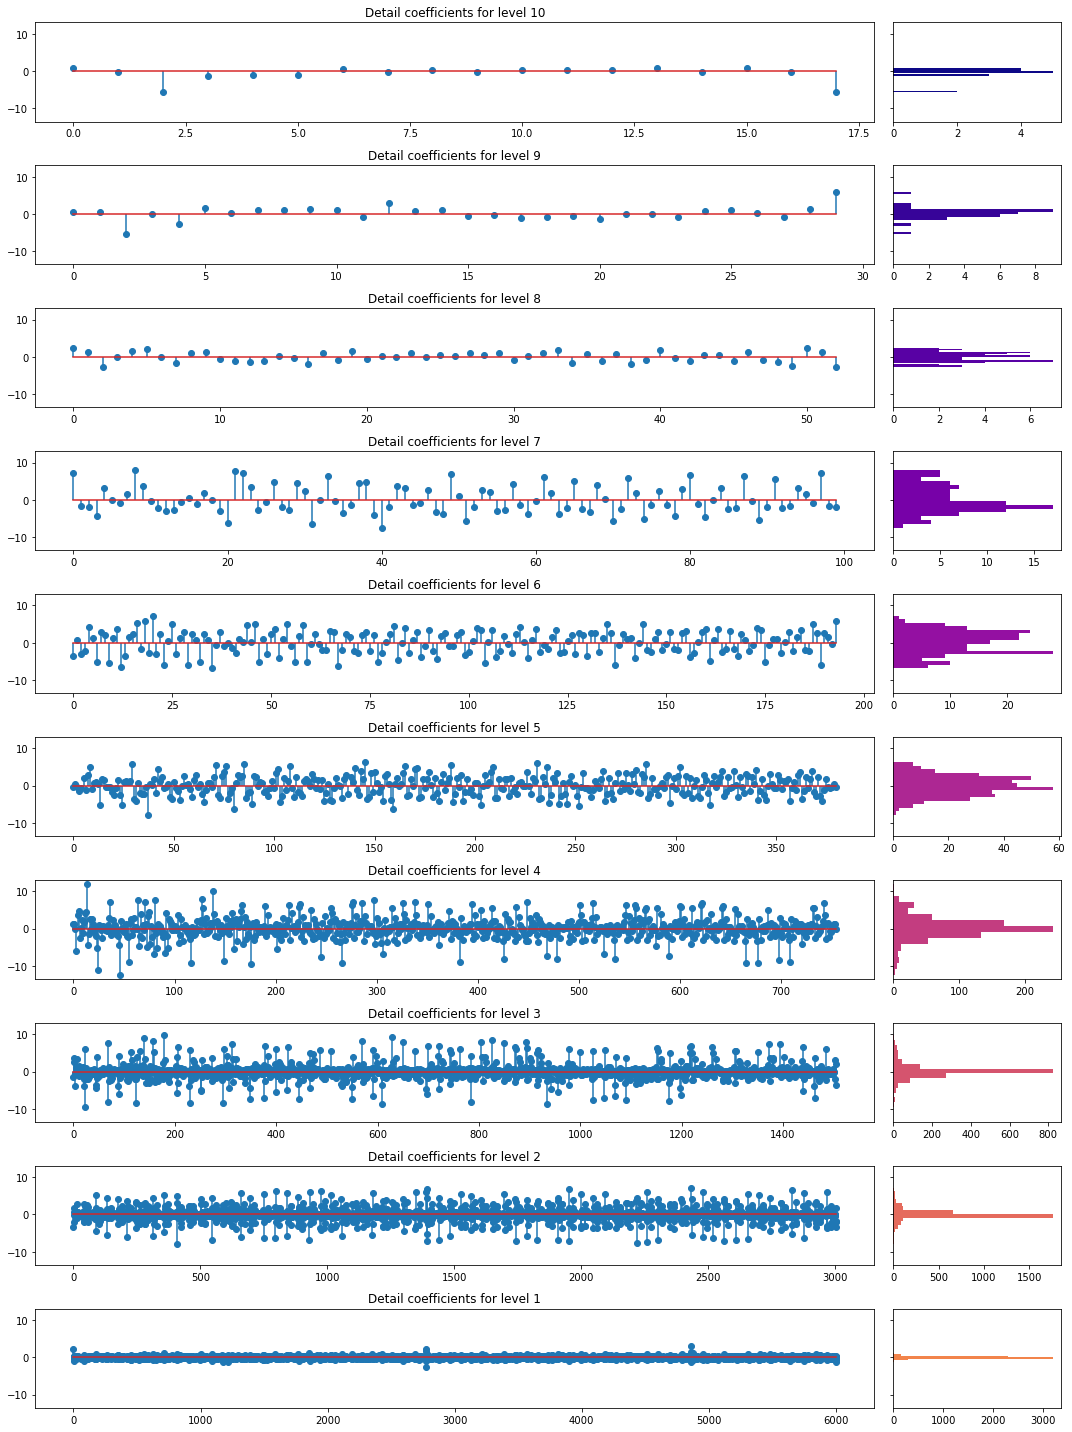

In [42]:
# sampling rate is 200 Hz, so maximum frequency band is -100,100 Hz ignoring negative frequencies because it's a real signal
# first level of detail contains frequencies from 50 to 100
# second level of detail 25 to 50
# third from 12.5 to 25
# fourth from 6.25 to 12.5 etc....

fig,axs = plt.subplots(len(coefs[1:]),2,figsize=[15,20],gridspec_kw={'width_ratios': [5, 1]},sharey=True)
colors=[cm.plasma(x) for x in np.linspace(0,0.7,len(coefs[1:]))]
for id,coef_details in enumerate(coefs[1:]):
    axs[id,0].stem(coef_details,markerfmt='C0o')
    axs[id,0].set_title("Detail coefficients for level "+str(n_max-id))
    axs[id,1].hist(coef_details,bins=15,orientation='horizontal',color=colors[id])

fig.tight_layout()
plt.show()

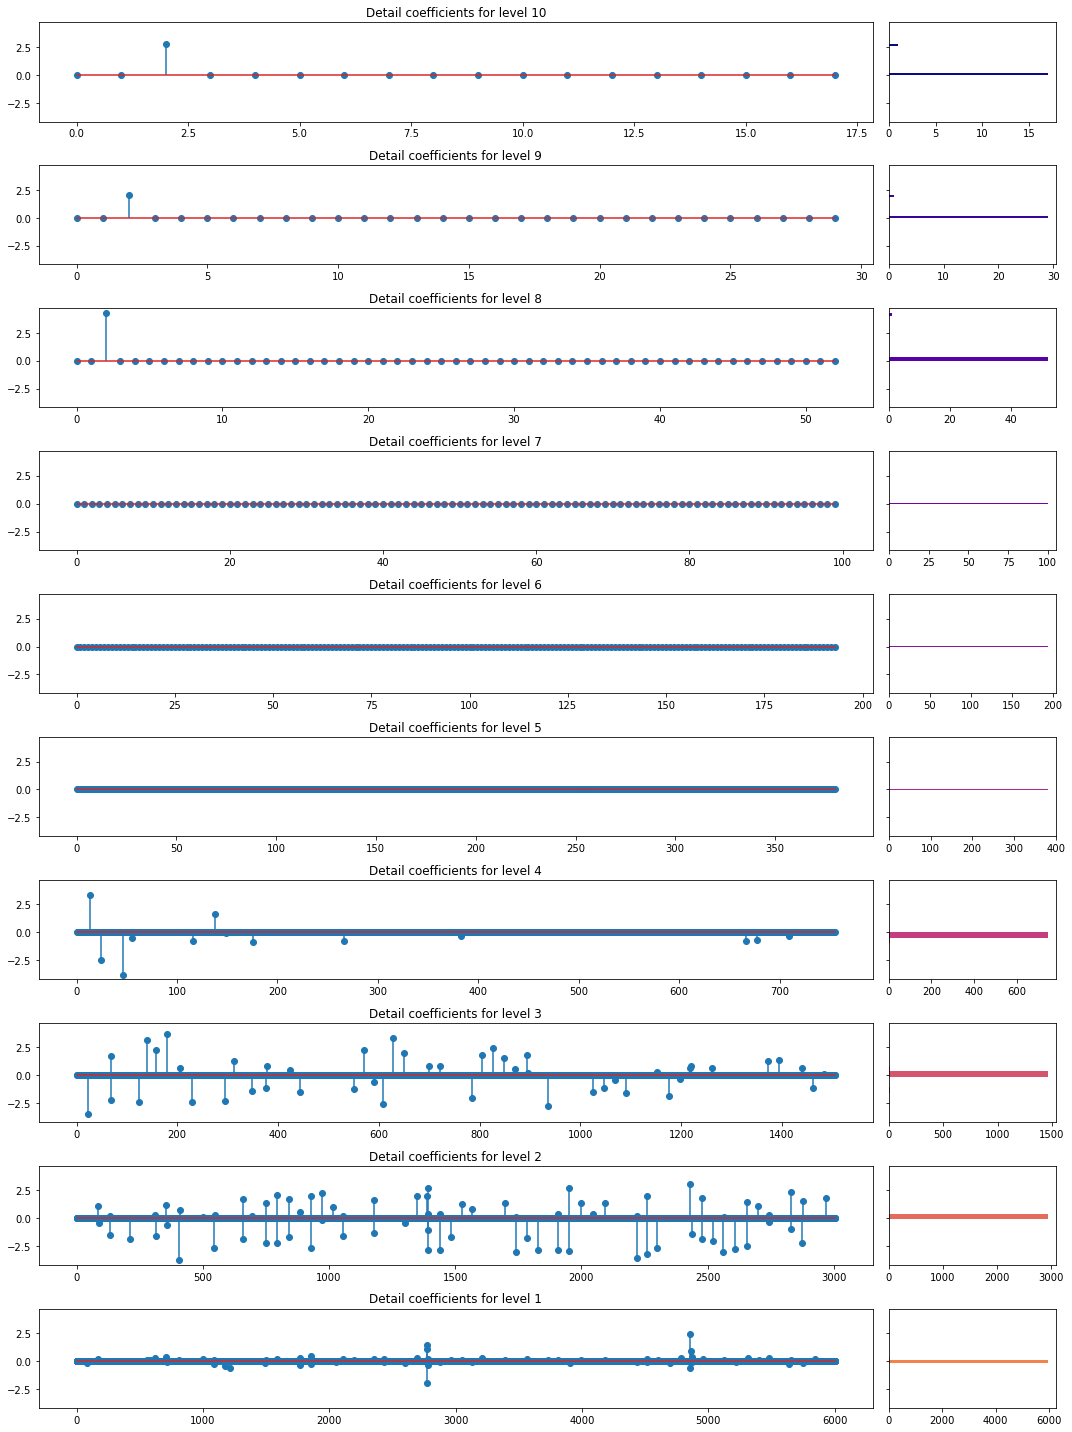

In [39]:
# now let's filter such coefficients:
coefs_filtered = coefs.copy()

fig,axs = plt.subplots(len(coefs_filtered[1:]),2,figsize=[15,20],gridspec_kw={'width_ratios': [5, 1]},sharey=True)
colors=[cm.plasma(x) for x in np.linspace(0,0.7,len(coefs_filtered[1:]))]
for id in range(1,len(coefs_filtered)):
    threshold = 3*np.std(coefs_filtered[id])
    # threshold = 
    coefs_filtered[id] = pywt.threshold(coefs_filtered[id], threshold)
    axs[id-1,0].stem(coefs_filtered[id],markerfmt='C0o')
    axs[id-1,0].set_title("Detail coefficients for level "+str(n_max-id+1))
    axs[id-1,1].hist(coefs_filtered[id],bins=15,orientation='horizontal',color=colors[id-1])

fig.tight_layout()
plt.show()

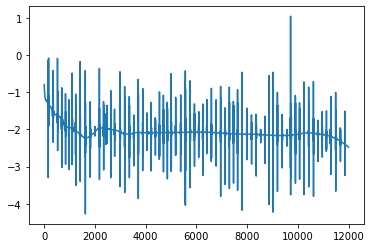

In [40]:
x_re = pywt.waverec(coefs_filtered,wvlet)
plt.plot(x_re)